Imports

In [1]:
import os
import cv2
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import seaborn 
import tensorflow as tf
from IPython import display
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.losses import SparseCategoricalCrossentropy,CategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy,CategoricalAccuracy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping



import warnings
warnings.filterwarnings('ignore')

### Dataset Exploration

In [2]:
root_path = "D:/NLP internship/ArSL translation/ArSL dataset/RGB ArSL dataset/"

# Collect all alphapets
alphabets = os.listdir(root_path)
num_alpha = len(alphabets)

print(f"Total number of individuals: {num_alpha}\n")
print(f"Name of the individuals : \n\t{alphabets}")

Total number of individuals: 31

Name of the individuals : 
	['Ain', 'Al', 'Alef', 'Beh', 'Dad', 'Dal', 'Feh', 'Ghain', 'Hah', 'Heh', 'Jeem', 'Kaf', 'Khah', 'Laa', 'Lam', 'Meem', 'Noon', 'Qaf', 'Reh', 'Sad', 'Seen', 'Sheen', 'Tah', 'Teh', 'Teh_Marbuta', 'Thal', 'Theh', 'Waw', 'Yeh', 'Zah', 'Zain']


In [3]:
import pandas as pd
Data_Alph = pd.DataFrame({'label': alphabets})
print(Data_Alph)

          label
0           Ain
1            Al
2          Alef
3           Beh
4           Dad
5           Dal
6           Feh
7         Ghain
8           Hah
9           Heh
10         Jeem
11          Kaf
12         Khah
13          Laa
14          Lam
15         Meem
16         Noon
17          Qaf
18          Reh
19          Sad
20         Seen
21        Sheen
22          Tah
23          Teh
24  Teh_Marbuta
25         Thal
26         Theh
27          Waw
28          Yeh
29          Zah
30         Zain


In [4]:
# Label counts 
# from collections import Counter
imgs_per_alphabet = [len(os.listdir(root_path + harf)) for harf in alphabets]
label_counts = dict(zip(alphabets, imgs_per_alphabet))
print(f"Number of Images/Person :\n",label_counts)

# label_counts = Counter(label for label in alphapets)
# label_counts

Number of Images/Person :
 {'Ain': 244, 'Al': 276, 'Alef': 287, 'Beh': 307, 'Dad': 266, 'Dal': 235, 'Feh': 255, 'Ghain': 230, 'Hah': 246, 'Heh': 253, 'Jeem': 210, 'Kaf': 264, 'Khah': 250, 'Laa': 268, 'Lam': 260, 'Meem': 253, 'Noon': 237, 'Qaf': 219, 'Reh': 227, 'Sad': 270, 'Seen': 266, 'Sheen': 278, 'Tah': 226, 'Teh': 311, 'Teh_Marbuta': 257, 'Thal': 202, 'Theh': 305, 'Waw': 249, 'Yeh': 272, 'Zah': 232, 'Zain': 201}


### Dataset Cleaning

In [5]:
print(Data_Alph.isnull().sum())

label    0
dtype: int64


In [6]:
Data_Alph.fillna(value='missing', inplace=True)

In [7]:
# Choosing random file paths
from glob import glob
filepaths = [path  for name in alphabets for path in glob(root_path + name + '/*')]

np.random.shuffle(filepaths)
print(f"Total number of images to be loaded : {len(filepaths)}")

IMG_W, IMG_H, IMG_C = (160, 160, 3)

Total number of images to be loaded : 7856


In [8]:
filepaths = sorted(filepaths)

In [9]:
filepaths[800].split("\\")[1].split('_')

['Alef', '93.jpg']

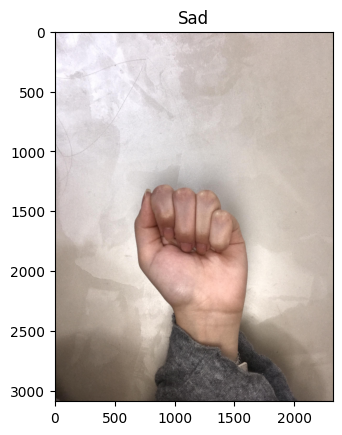

In [10]:
import random
image_path = random.choice(filepaths)
letter_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plt.title(image_path.split("\\")[1].split("_")[0])
plt.imshow(letter_image)

### Extracting the labels from the pictures 
This method only works for this naming convention as we will take a path like so:  
`D:/NLP internship/ArSL dataset/RGB ArSL dataset/Alef\Alef_93.jpg`  
* Split by `\` to separate the root path from the image name  
* Split the image name by `_` to separate the label fromt the number id and the extension 



In [11]:
len(filepaths)

7856

In [12]:
# extract the string label of all the pictures
string_labels = [path.split("\\")[1].split("_")[0] for path in filepaths]
print(len(string_labels))

7856


In [13]:
# convert the labels from string to index
all_labels = [alphabets.index(label) for label in string_labels]
print(len(all_labels))

7856


In [14]:
import mediapipe as mp

all_hands_landmarks =[]
skipped_images = []
recognized_hands_labels = []
# using mediapipe to get the coordinnates of the hands landmark
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.1) as hands:
  for file, label in zip(filepaths, all_labels):
    # Read an image, flip it around y-axis for correct handedness output (see
    # above).
    image = cv2.flip(cv2.imread(file), 1)
    # Convert the BGR image to RGB before processing.
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Print handedness and draw hand landmarks on the image. (left or right)
    #print('Handedness:', results.multi_handedness)
    if not results.multi_hand_landmarks:
      skipped_images.append(file)
      continue
    else:
      recognized_hands_labels.append(label)
    image_height, image_width, _ = image.shape
    annotated_image = image.copy()

    all_hands_landmarks.append(results.multi_hand_landmarks)

In [15]:
import copy
import itertools

def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(
        itertools.chain.from_iterable(temp_landmark_list))

    # Normalization
    max_value = max(list(map(abs, temp_landmark_list)))

    def normalize_(n):
        return n / max_value

    temp_landmark_list = list(map(normalize_, temp_landmark_list))

    return temp_landmark_list

In [16]:
def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Keypoint
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

In [17]:
len(all_hands_landmarks)  # number of pictures recognized as hands

7450

In [18]:
print(filepaths)

['D:/NLP internship/ArSL dataset/RGB ArSL dataset/Ain\\Ain_0.jpg', 'D:/NLP internship/ArSL dataset/RGB ArSL dataset/Ain\\Ain_1.jpg', 'D:/NLP internship/ArSL dataset/RGB ArSL dataset/Ain\\Ain_10.jpeg', 'D:/NLP internship/ArSL dataset/RGB ArSL dataset/Ain\\Ain_100.jpg', 'D:/NLP internship/ArSL dataset/RGB ArSL dataset/Ain\\Ain_101.jpg', 'D:/NLP internship/ArSL dataset/RGB ArSL dataset/Ain\\Ain_102.jpg', 'D:/NLP internship/ArSL dataset/RGB ArSL dataset/Ain\\Ain_103.jpg', 'D:/NLP internship/ArSL dataset/RGB ArSL dataset/Ain\\Ain_104.jpg', 'D:/NLP internship/ArSL dataset/RGB ArSL dataset/Ain\\Ain_105.jpg', 'D:/NLP internship/ArSL dataset/RGB ArSL dataset/Ain\\Ain_106.jpg', 'D:/NLP internship/ArSL dataset/RGB ArSL dataset/Ain\\Ain_107.jpeg', 'D:/NLP internship/ArSL dataset/RGB ArSL dataset/Ain\\Ain_108.jpg', 'D:/NLP internship/ArSL dataset/RGB ArSL dataset/Ain\\Ain_109.jpg', 'D:/NLP internship/ArSL dataset/RGB ArSL dataset/Ain\\Ain_11.jpg', 'D:/NLP internship/ArSL dataset/RGB ArSL dataset/Ai

In [19]:
all_normalized_landmarks = []
for path, landmark_list in zip(filepaths, all_hands_landmarks):
    # print(path)
    # print(landmark_list[0])
    # for hand_landmarks in landmark_list[0]:
    normalized_landmarks = calc_landmark_list(cv2.imread(path), landmark_list[0])
    normalized_landmarks = pre_process_landmark(normalized_landmarks)
    all_normalized_landmarks.append(normalized_landmarks)

In [20]:
all_normalized_landmarks

[[0.0,
  0.0,
  -0.07097208207198116,
  -0.22973427514295325,
  -0.2122435250588631,
  -0.3767238479650185,
  -0.3837874201143626,
  -0.4113689875546586,
  -0.5351496804574504,
  -0.40766902119071646,
  -0.22300706357214933,
  -0.49983181971072993,
  -0.5398587285570131,
  -0.5045408678102926,
  -0.7077026572485705,
  -0.4937773292970064,
  -0.86209216279852,
  -0.49175916582576523,
  -0.23511604439959638,
  -0.35856037672384794,
  -0.6057854019508914,
  -0.35788765556676755,
  -0.8308106289942818,
  -0.3491422805247225,
  -1.0,
  -0.32996972754793136,
  -0.27749747729566093,
  -0.20248906828119745,
  -0.546585940127817,
  -0.21459804910864447,
  -0.4530776992936428,
  -0.16885301042717793,
  -0.3504877228388833,
  -0.16178943827783385,
  -0.3239152371342079,
  -0.07971745711402624,
  -0.5200134544231416,
  -0.10427177934746047,
  -0.4419778002018164,
  -0.0682811974436596,
  -0.3605785401950891,
  -0.07097208207198116],
 [0.0,
  0.0,
  -0.06620370370370371,
  -0.20185185185185187,
  -

In [22]:
recognized_hands_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [23]:
# recognized_hands_labels = [label[0] for label in recognized_hands_labels]
# recognized_hands_labels

In [24]:
# Assuming all_normalized_landmarks is a 2D list/array (number of images X 42)
# and recognized_hands_labels is a 1D list/array with the labels for each image

# Create a DataFrame from the landmarks
df_landmarks = pd.DataFrame(all_normalized_landmarks)

# Add the labels to the DataFrame
df_landmarks['label'] = recognized_hands_labels

# Write the DataFrame to a CSV file
df_landmarks.to_csv('hand_gesture_data.csv', index=False)

# If you want to save it as an Excel file instead of CSV:
#df_landmarks.to_excel('hand_gesture_data.xlsx', index=False)